In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
import joblib
import shap
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score,  make_scorer, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 1e-3
weight_decay = 1e-4
batch_size = 64
num_epochs = 75
num_runs = 2
max_patience = 13

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

Using device: cuda


In [2]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
        
    return dfs

def dataset_summary(df, y=None, threshold=0.7):

    df_copy = df.copy()

    if y is not None and y.name in df_copy.columns:
        df_copy = df_copy.drop(columns=[y.name])
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in cat_cols:
        df_copy[col] = df_copy[col].astype("category").cat.codes
    
    print(f"Dataset shape: {df_copy.shape}")
    print(f"Total rows: {len(df_copy)}")
    print(f"Total duplicate rows: {df_copy.duplicated().sum()}")

    summary = pd.DataFrame({
        "dtype": df_copy.dtypes,
        "non_null": df_copy.notna().sum(),
        "missing": df_copy.isna().sum(),
        "missing_%": (df_copy.isna().mean() * 100).round(2),
        "unique": df_copy.nunique()
    })

    numeric_cols = df_copy.select_dtypes(include="number").columns
    feature_cols = df_copy.columns.tolist()
    desc = df_copy[numeric_cols].describe().T
    desc["skew"] = df_copy[numeric_cols].skew()
    summary = summary.join(desc[["mean", "std", "min", "25%", "50%", "75%", "max", "skew"]])

    if y is not None:
        df_copy['target'] = y
        summary["corr_with_target"] =  df_copy.corr()['target'].drop('target')

    corr_matrix = df_copy.corr(numeric_only=True)
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
    )
    
    high_corr = corr_pairs[abs(corr_pairs) > threshold]
    
    corr_map = {}
    for (f1, f2), val in high_corr.items():
        corr_map.setdefault(f1, []).append(f"{f2} ({val:.2f})")
        corr_map.setdefault(f2, []).append(f"{f1} ({val:.2f})")
    
    summary["high_corr_flag"] = summary.index.map(lambda col: col in corr_map)
    summary["high_corr_with"] = summary.index.map(
        lambda col: ", ".join(corr_map[col]) if col in corr_map else ""
    )

    return summary.sort_values("missing_%", ascending=False)

def outlier_handling(df, target_col, n_high=100, n_low=10):

    df_copy = df.copy()
    
    numeric_cols = df_copy.select_dtypes(include=["number"]).columns.tolist()
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(0)
    
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]

    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42,
        min_samples_leaf=20
    )
    hgb.fit(X, y)

    y_pred_proba = hgb.predict_proba(X)[:, 1]

    df_copy["__pred_proba__"] = y_pred_proba
    df_sorted = df_copy.sort_values("__pred_proba__", ascending=True).reset_index(drop=True)

    total_rows = len(df_sorted)
    start_idx = n_low
    end_idx = max(0, total_rows - n_high)
    df_filtered = df_sorted.iloc[start_idx:end_idx].drop(columns="__pred_proba__").reset_index(drop=True)

    dropped = total_rows - len(df_filtered)
    
    print(f"Dropped {dropped} outlier rows (lowest {n_low}, highest {n_high})")

    return df_filtered

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    
    print(f"Dropped cols: {feature_cols_to_drop}")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    
    df_e = df.copy()

    NumberOfTime3059DaysPastDueNotWorse = df_e["NumberOfTime30-59DaysPastDueNotWorse"].fillna(0).clip(upper=10)
    NumberOfTimes90DaysLate = df_e["NumberOfTimes90DaysLate"].fillna(0).clip(upper=10)
    NumberOfTime6089DaysPastDueNotWorse = df_e["NumberOfTime60-89DaysPastDueNotWorse"].fillna(0).clip(upper=10)

    TotalPastDue = (
        NumberOfTime3059DaysPastDueNotWorse
        + NumberOfTimes90DaysLate
        + NumberOfTime6089DaysPastDueNotWorse
    )
    TotalPastDueCapped = TotalPastDue.clip(upper=10)

    RevolvingUtilizationCapped = df_e["RevolvingUtilizationOfUnsecuredLines"].clip(upper=5.0).fillna(0.0).replace(0, np.nan)
    RevolvingUtilizationCappedLog = np.log1p(RevolvingUtilizationCapped)

    AgeSafe = df_e["age"].replace(0, np.nan)

    MonthlyIncomeSafe = df_e["MonthlyIncome"]

    DebtRatioCapped = df_e["DebtRatio"].clip(upper=10000.0)

    CreditLinesSafe = df_e["NumberOfOpenCreditLinesAndLoans"].replace(0, np.nan)

    DebtToIncome = DebtRatioCapped * MonthlyIncomeSafe
    IncomePerCreditLine = MonthlyIncomeSafe / CreditLinesSafe

    AgeRisk = np.where(AgeSafe < 25, 1.0,
                 np.where(AgeSafe < 35, 0.8,
                 np.where(AgeSafe < 50, 0.6, 0.4)))

    DelinquencyScore = (
        NumberOfTime3059DaysPastDueNotWorse +
        NumberOfTime6089DaysPastDueNotWorse * 2 +
        NumberOfTimes90DaysLate * 3
    )

    UtilizationPerAge = RevolvingUtilizationCappedLog / AgeSafe

    HasAnyDelinquency = (TotalPastDue > 0).astype(int)

    df_e["RevolvingUtilizationCappedLog"] = RevolvingUtilizationCappedLog
    df_e["TotalPastDueCapped"] = TotalPastDueCapped
    
    df_e["DelinquencyScore"] = DelinquencyScore
    df_e["HasAnyDelinquency"] = HasAnyDelinquency
    df_e["HasMajorDelinquency"] = (
        (NumberOfTime6089DaysPastDueNotWorse > 0) |
        (NumberOfTimes90DaysLate > 0)
    ).astype(int)

    df_e["UtilizationPerAge"] = UtilizationPerAge
    df_e["UtilizationTimesDelinquency"] = UtilizationPerAge * HasAnyDelinquency
    df_e["LatePaymentsPerCreditLine"] = TotalPastDue / CreditLinesSafe
    df_e["UtilizationPerCreditLine"] = RevolvingUtilizationCappedLog / CreditLinesSafe

    df_e["IncomePerCreditLine"] = IncomePerCreditLine
    df_e["DebtToIncomeAgeRisk"] = DebtToIncome * AgeRisk

    df_e["HighAgeRiskFlag"] = (AgeRisk <= 0.4).astype(int)

    DelinquencyScore_bins = [-1, 0, 1, 3, 6, np.inf]
    DelinquencyScore_labels = ["None", "Few", "Moderate", "Frequent", "Chronic"]
    df_e["DelinquencyBucket"] = pd.cut(DelinquencyScore, bins=DelinquencyScore_bins, labels=DelinquencyScore_labels)

    Utilization_bins = [-0.01, 0.1, 0.3, 0.6, 0.9, 1.5, 10]
    Utilization_labels = ["Very Low", "Low", "Moderate", "High", "Very High", "Extreme"]
    UtilizationBucket = pd.cut(RevolvingUtilizationCapped, bins=Utilization_bins, labels=Utilization_labels)

    Late_bins = [-1, 0, 1, 3, 6, np.inf]
    Late_labels = ["NoLate", "FewLate", "ModerateLate", "FrequentLate", "ChronicLate"]
    LatePaymentBucket = pd.cut(TotalPastDue, bins=Late_bins, labels=Late_labels)

    df_e["UtilizationBucketLateBucket"] = (
        UtilizationBucket.astype(str) + "_" + LatePaymentBucket.astype(str)
    )

    engineered_cols = [
        "TotalPastDueCapped",
        "DelinquencyScore",
        "HasAnyDelinquency",
        "HasMajorDelinquency",
        "UtilizationPerAge",
        "LatePaymentsPerCreditLine",
        "IncomePerCreditLine",
        "DebtToIncomeAgeRisk",
        "DelinquencyBucket",
        "UtilizationBucketLateBucket",
        "UtilizationPerCreditLine",
        "UtilizationTimesDelinquency",
        "HighAgeRiskFlag",
        "RevolvingUtilizationCappedLog"
    ]

    engineered_df = df_e[engineered_cols]

    print(f"Engineered {len(engineered_df)} features")
    print(f"Engineered cols: {list(engineered_df.columns)}")

    return engineered_df

def drop_high_missing_cols(df, threshold=0.3):

    missing_frac = df.isna().mean().sort_values(ascending=False)
    missing_summary = pd.DataFrame({
        'MissingCount': df.isna().sum(),
        'MissingPercent': (missing_frac * 100).round(2)
    })

    if df.isna().sum().sum() > 0:
        print(missing_summary.to_string())
    
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped: {len(hm_cols_to_drop)} high missing cols")
        print(f"Dropped cols: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No high missing cols dropped")
        
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):

    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    unique_counts = df[cat_cols].nunique().sort_values(ascending=False)
    unique_summary = pd.DataFrame({
        'UniqueCount': unique_counts,
        'UniquePercent': (unique_counts / len(df) * 100).round(2)
    })

    if cat_cols:
        print(unique_summary.to_string())

    hc_cols_to_drop = unique_counts[unique_counts > threshold].index.tolist()

    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped: {len(hc_cols_to_drop)} high cardinality cols")
        print(f"Dropped cols: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high cardinality cols dropped")

    return df_high, hc_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):
    
    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    rare_maps = {}

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True, dropna=True)
        rare_cats = [c for c in freqs[freqs < threshold].index]
        if rare_cats:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            print(f"Column '{col}': collapsed {len(rare_cats)} rare categories: {rare_cats}")
        else:
            print(f"Column '{col}': no rare categories to collapse")

    return df_copy, rare_maps

def find_best_param(X_train, y_train):
    
    neg_count = sum(y_train == 0)
    pos_count = sum(y_train == 1)
    
    base_scale_pos_weight = neg_count / pos_count
    
    param_grid = {
        "max_depth": [4, 5, 6, 7, 8],
        "min_child_weight": [1, 3, 5, 7],
        "gamma": [0, 0.2, 0.5, 1.0],
        "subsample": [0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
        "reg_alpha": [0, 0.05, 0.1, 0.3],
        "reg_lambda": [0.5, 0.8, 1.0, 1.2],
        "learning_rate": [0.01, 0.03, 0.05],
        "scale_pos_weight": [base_scale_pos_weight * m for m in [1.0, 1.5, 2.0, 2.5, 3.0]]
    }
    
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=800,
        random_state=42,
        n_jobs=-1,
    )
    
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_grid,
        n_iter=30,  
        scoring=f2_scorer,
        cv=3,      
        verbose=0,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    print("Best params:", search.best_params_)

    return search.best_params_

def select_features(df, target, n_to_keep=10):
    
    df_temp = df.copy()
    
    cat_cols = df_temp.select_dtypes(include=["object", "category"]).columns.tolist()
    df_model = df_temp.copy()
    for col in cat_cols:
        df_model[col] = df_model[col].astype("category").cat.codes

    feature_cols = df_model.columns.tolist()

    X_train, _, y_train, _ = train_test_split(
        df_model[feature_cols],
        target,
        test_size=0.2,
        random_state=42,
        stratify=target,
    )

    X_train = X_train.astype(np.float32)

    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()

    best_param = {
        'subsample': 0.6,
        'scale_pos_weight':
        14.090657712818487,
        'reg_lambda': 0.8,
        'reg_alpha': 0.1,
        'min_child_weight': 5,
        'max_depth': 4,
        'learning_rate': 0.03,
        'gamma': 1.0,
        'colsample_bytree': 0.6
    }
    
    model = xgb.XGBClassifier(
        **best_param,
        objective="binary:logistic",
        eval_metric=["auc"],
        n_estimators=800,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
    )
    
    model.fit(X_train, y_train, verbose=False)

    all_features = model.get_booster().feature_names
    importance_dict = model.get_booster().get_score(importance_type="gain")
    full_importance = {feat: importance_dict.get(feat, 0.0) for feat in all_features}

    importance_df = (
        pd.DataFrame({
            "Feature": list(full_importance.keys()),
            "Importance": list(full_importance.values())
        })
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )

    top_features = importance_df["Feature"].head(n_to_keep).tolist()
    dropped_features = [f for f in feature_cols if f not in top_features]

    print(f"Kept {len(top_features)} select features")
    print(f"Dropped {len(dropped_features)} features")
    if dropped_features:
        print(f"Dropped cols: {dropped_features}")
    print(importance_df)

    return df_temp[top_features].copy(), dropped_features

def impute_and_scale(df):
    
    df_copy = df.copy()
    
    num_imputer = None
    robust_scaler = None
    std_scaler = None
    cat_imputer=None
    cat_maps = {}
    skewed_cols = []

    num_col_order = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_col_order = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    if num_col_order:
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        num_imputer = SimpleImputer(strategy='median')
        df_copy[num_col_order] = num_imputer.fit_transform(df_copy[num_col_order])
        skewness = df_copy[num_col_order].skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols])
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols])

    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object') 
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_col_order] = cat_imputer.fit_transform(df_copy[cat_col_order]) 
        for col in cat_col_order:
            unique_cats = df_copy[col].astype(str).unique()
            cat_maps[col] = {cat: idx for idx, cat in enumerate(unique_cats)}

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_cols, cat_col_order, cat_maps, imputed_flags

def transform_val_test(
    df, 
    cols_to_drop=None, 
    num_imputer=None,
    cat_imputer=None,
    robust_scaler=None, 
    std_scaler=None,
    num_col_order=None, 
    skewed_cols=None,
    cat_col_order=None,
    rare_maps=None,
    train_columns=None
):
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if num_col_order:     
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = num_imputer.transform(df_copy[num_col_order])
        skewed_cols = skewed_cols or []
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols and robust_scaler:
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols])
        if normal_cols and std_scaler:
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols])
            
    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object')
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        for col in cat_col_order:
            if rare_maps and col in rare_maps:
                rare_categories = list(rare_maps[col])
                df_copy[col] = df_copy[col].replace(rare_categories, 'Other')
        df_copy[cat_col_order] = cat_imputer.transform(df_copy[cat_col_order])
   
    if train_columns is not None:
        df_copy = df_copy.reindex(columns=train_columns, fill_value=0)

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, imputed_flags

def check_and_drop_duplicates(df, target=None):
    
    df_cleaned = df.drop_duplicates()
    
    count = df.duplicated().sum()

    if target is None:
        print(f"Dropped: {count} duplicates")
        return df_cleaned

    target_cleaned = pd.Series(target).reindex(df_cleaned.index)
    mask = target_cleaned.notna()
    df_cleaned = df_cleaned[mask].reset_index(drop=True)
    target_cleaned = target_cleaned[mask].reset_index(drop=True)

    print(f"Dropped: {count} duplicates")
    return df_cleaned, target_cleaned

def threshold_by_target_recall(y_true, y_probs, thresholds, target_recall):
    
    y_true = np.asarray(y_true).astype(int)
    y_probs = np.asarray(y_probs).astype(float)
    thresholds = np.asarray(thresholds).astype(float)

    preds = y_probs[:, None] > thresholds[None, :]

    TP = (preds & (y_true[:, None] == 1)).sum(axis=0)
    FN = ((~preds) & (y_true[:, None] == 1)).sum(axis=0)

    recall = TP / (TP + FN + 1e-8)

    closest_idx = np.argmin(np.abs(recall - target_recall))
    return thresholds[closest_idx]

In [3]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [4]:
# Summary
dataset_summary(df_train, df_train["SeriousDlqin2yrs"])

Dataset shape: (150000, 10)
Total rows: 150000
Total duplicate rows: 646


,dtype,non_null,missing,missing_%,unique,mean,std,min,25%,50%,75%,max,skew,corr_with_target,high_corr_flag,high_corr_with
MonthlyIncome,float64,120269,29731,19.82,13594,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,114.040318,-0.019746,False,
NumberOfDependents,float64,146076,3924,2.62,13,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,1.588242,0.046048,False,
age,int64,150000,0,0.00,86,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.188995,-0.115386,False,
RevolvingUtilizationOfUnsecuredLines,float64,150000,0,0.00,125728,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,97.631574,-0.001802,False,
DebtRatio,float64,150000,0,0.00,114194,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,95.157793,-0.007602,False,
NumberOfTime30-59DaysPastDueNotWorse,int64,150000,0,0.00,16,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,22.597108,0.125587,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTimes90DaysLate (0.98)"
NumberOfOpenCreditLinesAndLoans,int64,150000,0,0.00,58,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,1.215314,-0.029669,False,
NumberOfTimes90DaysLate,int64,150000,0,0.00,19,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,23.087345,0.117175,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.98)"
NumberRealEstateLoansOrLines,int64,150000,0,0.00,28,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,3.482484,-0.007038,False,
NumberOfTime60-89DaysPastDueNotWorse,int64,150000,0,0.00,13,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,23.331743,0.102261,True,"NumberOfTimes90DaysLate (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.99)"


In [5]:
# Drop duplicates
df_train = check_and_drop_duplicates(df_train)

Dropped: 609 duplicates


In [6]:
# Outlier Handling
numeric_df = df_train.select_dtypes(include=['number'])

df_train = df_train[df_train['age'] > 0].reset_index(drop=True) 

df_train = df_train.sort_values(by="MonthlyIncome", ascending=False).iloc[1:].reset_index(drop=True) 

df_train = df_train[df_train['age'] > 0].reset_index(drop=True)

df_filtered = outlier_handling(
    df_train,
    target_col="SeriousDlqin2yrs",
    n_high=130, 
    n_low=30
)

df_filtered.describe()

Dropped 160 outlier rows (lowest 30, highest 130)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149229.000000,149229.000000,149229.000000,149229.00000,149229.000000,1.492290e+05,149229.000000,149229.000000,149229.000000,149229.000000,149229.000000
mean,0.066267,6.076759,52.306978,0.37423,354.503939,5.352233e+03,8.483096,0.216995,1.022321,0.192670,0.740118
std,0.248750,250.399417,14.720557,3.61494,2042.760501,1.064388e+04,5.136317,3.584188,1.129660,3.568789,1.107738
min,0.000000,0.000000,21.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030109,41.000000,0.00000,0.177387,1.600000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.153960,52.000000,0.00000,0.367899,4.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.555169,63.000000,0.00000,0.873533,7.405000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.00000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [7]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_filtered)
print(target.value_counts())

Dropped cols: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139340
1      9889
Name: count, dtype: int64


In [8]:
original_cols = df_features.select_dtypes(include=['number']).columns.tolist()
print(original_cols)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [9]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [10]:
# Engineer_features
df_e = engineer_features(X_train)

Engineered 95506 features
Engineered cols: ['TotalPastDueCapped', 'DelinquencyScore', 'HasAnyDelinquency', 'HasMajorDelinquency', 'UtilizationPerAge', 'LatePaymentsPerCreditLine', 'IncomePerCreditLine', 'DebtToIncomeAgeRisk', 'DelinquencyBucket', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'UtilizationTimesDelinquency', 'HighAgeRiskFlag', 'RevolvingUtilizationCappedLog']


In [11]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_e, threshold=0.25)

                               MissingCount  MissingPercent
DebtToIncomeAgeRisk                       0            0.00
DelinquencyBucket                         0            0.00
DelinquencyScore                          0            0.00
HasAnyDelinquency                         0            0.00
HasMajorDelinquency                       0            0.00
HighAgeRiskFlag                           0            0.00
IncomePerCreditLine                    1043            1.09
LatePaymentsPerCreditLine              1043            1.09
RevolvingUtilizationCappedLog          6831            7.15
TotalPastDueCapped                        0            0.00
UtilizationBucketLateBucket               0            0.00
UtilizationPerAge                      6831            7.15
UtilizationPerCreditLine               7874            8.24
UtilizationTimesDelinquency            6831            7.15
No high missing cols dropped


In [12]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

                             UniqueCount  UniquePercent
UtilizationBucketLateBucket           35           0.04
DelinquencyBucket                      5           0.01
No high cardinality cols dropped


In [13]:
# Collapse rare categories
df_collapsed, rare_maps = collapse_rare_categories(df_high, threshold=0.05)

Column 'DelinquencyBucket': collapsed 2 rare categories: ['Frequent', 'Chronic']
Column 'UtilizationBucketLateBucket': collapsed 29 rare categories: ['Very Low_FewLate', 'Very High_FewLate', 'Low_FewLate', 'Moderate_FewLate', 'Very High_ModerateLate', 'High_FewLate', 'High_ModerateLate', 'Moderate_ModerateLate', 'Very High_FrequentLate', 'Low_ModerateLate', 'nan_FewLate', 'Very Low_ModerateLate', 'High_FrequentLate', 'Very High_ChronicLate', 'nan_ModerateLate', 'Moderate_FrequentLate', 'Extreme_NoLate', 'Low_FrequentLate', 'High_ChronicLate', 'Very Low_FrequentLate', 'Extreme_ModerateLate', 'Moderate_ChronicLate', 'nan_FrequentLate', 'Extreme_FewLate', 'Extreme_FrequentLate', 'Low_ChronicLate', 'nan_ChronicLate', 'Extreme_ChronicLate', 'Very Low_ChronicLate']


In [14]:
# Feature selection
df_selected, fs_cols_to_drop = select_features(df_collapsed, y_train, n_to_keep=14)

Kept 14 select features
Dropped 0 features
                          Feature  Importance
0       LatePaymentsPerCreditLine  388.010773
1                DelinquencyScore  358.740082
2              TotalPastDueCapped  298.515686
3     UtilizationTimesDelinquency  136.970551
4               DelinquencyBucket  135.709625
5     UtilizationBucketLateBucket  101.313957
6               UtilizationPerAge   74.949860
7             HasMajorDelinquency   74.041748
8   RevolvingUtilizationCappedLog   60.334053
9             DebtToIncomeAgeRisk   44.571373
10       UtilizationPerCreditLine   40.673717
11            IncomePerCreditLine   36.476421
12              HasAnyDelinquency   35.808910
13                HighAgeRiskFlag   32.019653


In [15]:
# Impute and scale
X_train, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_col_order, cat_col_order, cat_maps, X_train_flags = impute_and_scale(
    df_selected
)

Imputed, flagged, and scaled features


In [16]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + hc_cols_to_drop + fs_cols_to_drop

X_val = engineer_features(X_val)
X_val, X_val_flags = transform_val_test(    
    X_val,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

X_test = engineer_features(X_test)
X_test, X_test_flags = transform_val_test(
    X_test,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

Engineered 23877 features
Engineered cols: ['TotalPastDueCapped', 'DelinquencyScore', 'HasAnyDelinquency', 'HasMajorDelinquency', 'UtilizationPerAge', 'LatePaymentsPerCreditLine', 'IncomePerCreditLine', 'DebtToIncomeAgeRisk', 'DelinquencyBucket', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'UtilizationTimesDelinquency', 'HighAgeRiskFlag', 'RevolvingUtilizationCappedLog']
Imputed, flagged, and scaled features
Engineered 29846 features
Engineered cols: ['TotalPastDueCapped', 'DelinquencyScore', 'HasAnyDelinquency', 'HasMajorDelinquency', 'UtilizationPerAge', 'LatePaymentsPerCreditLine', 'IncomePerCreditLine', 'DebtToIncomeAgeRisk', 'DelinquencyBucket', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'UtilizationTimesDelinquency', 'HighAgeRiskFlag', 'RevolvingUtilizationCappedLog']
Imputed, flagged, and scaled features


In [17]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)

Dropped: 2908 duplicates


In [18]:
#summary
dataset_summary(X_train, y_train)

Dataset shape: (92598, 28)
Total rows: 92598
Total duplicate rows: 0


,dtype,non_null,missing,missing_%,unique,mean,std,min,25%,50%,75%,max,skew,corr_with_target,high_corr_flag,high_corr_with
LatePaymentsPerCreditLine,float64,92598,0,0.0,201,0.076097,0.300314,0.000000,0.000000,0.000000,0.000000,30.000000,18.388191,0.309645,False,
DelinquencyScore,float64,92598,0,0.0,38,0.683308,2.492097,0.000000,0.000000,0.000000,0.000000,60.000000,11.231471,0.361854,True,TotalPastDueCapped (0.86)
TotalPastDueCapped,float64,92598,0,0.0,11,0.409426,1.097088,0.000000,0.000000,0.000000,0.000000,10.000000,4.180515,0.399287,True,"DelinquencyScore (0.86), HasAnyDelinquency (0.73)"
UtilizationTimesDelinquency,float64,92598,0,0.0,15842,0.001908,0.005049,0.000000,0.000000,0.000000,0.000000,0.071670,3.093738,0.364758,True,HasAnyDelinquency (0.74)
DelinquencyBucket,int8,92598,0,0.0,4,1.816249,0.657420,0.000000,2.000000,2.000000,2.000000,3.000000,-1.622637,0.053309,False,
UtilizationBucketLateBucket,int8,92598,0,0.0,7,3.209562,1.775414,0.000000,2.000000,3.000000,5.000000,6.000000,-0.241138,-0.057175,False,
UtilizationPerAge,float64,92598,0,0.0,82305,0.281012,0.771726,-0.416697,-0.314413,0.000000,0.681580,8.241714,1.678331,0.268645,True,RevolvingUtilizationCappedLog (0.92)
HasMajorDelinquency,float64,92598,0,0.0,2,0.087302,0.282279,0.000000,0.000000,0.000000,0.000000,1.000000,2.924108,0.362474,False,
RevolvingUtilizationCappedLog,float64,92598,0,0.0,80850,0.216556,0.633069,-0.440434,-0.320875,0.000000,0.673260,4.139011,1.117564,0.271133,True,UtilizationPerAge (0.92)
DebtToIncomeAgeRisk,float64,92598,0,0.0,72746,0.268932,1.608289,-0.444698,-0.422533,0.028949,0.586787,230.122301,66.268737,0.031882,False,


In [19]:
# Zero importance cols entered after running
zero_importance_cols = [
    "WasDebtToIncomeAgeRiskImputed",
    "WasDelinquencyBucketImputed",
    "WasDelinquencyScoreImputed",
    "WasHasAnyDelinquencyImputed",
    "WasHasMajorDelinquencyImputed",
    "WasHighAgeRiskFlagImputed",
    "WasIncomePerCreditLineImputed",
    "WasLatePaymentsPerCreditLineImputed",
    "WasRevolvingUtilizationCappedLogImputed",
    "WasTotalPastDueCappedImputed",
    "WasUtilizationBucketLateBucketImputed",
    "WasUtilizationPerAgeImputed",
    "WasUtilizationPerCreditLineImputed",
    "WasUtilizationTimesDelinquencyImputed"
]

X_train = X_train.drop(columns=zero_importance_cols)
X_val = X_val.drop(columns=zero_importance_cols)
X_test = X_test.drop(columns=zero_importance_cols)

flags_to_keep = [f for f in X_train_flags if f not in zero_importance_cols]

X_train_flags = flags_to_keep
X_val_flags = flags_to_keep
X_test_flags = flags_to_keep

In [20]:
# Encode
# Target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# NN
X_train_flags_nn = X_train[X_train_flags]
X_val_flags_nn = X_val[X_val_flags]
X_test_flags_nn = X_test[X_test_flags]

X_train_nn_encoded = pd.get_dummies(X_train, columns=cat_col_order)
X_val_nn_encoded = pd.get_dummies(X_val, columns=cat_col_order)
X_test_nn_encoded = pd.get_dummies(X_test, columns=cat_col_order)

X_val_nn_encoded = X_val_nn_encoded.reindex(columns=X_train_nn_encoded.columns)
X_test_nn_encoded = X_test_nn_encoded.reindex(columns=X_train_nn_encoded.columns)

X_train_nn_full = pd.concat([X_train_nn_encoded, X_train[num_col_order], X_train_flags_nn], axis=1)
X_val_nn_full = pd.concat([X_val_nn_encoded, X_val[num_col_order], X_val_flags_nn], axis=1)
X_test_nn_full = pd.concat([X_test_nn_encoded, X_test[num_col_order], X_test_flags_nn], axis=1)

# xgb
X_train_xgb = X_train
X_val_xgb = X_val
X_test_xgb = X_test

for col in cat_col_order:
    X_train_xgb[col] = X_train[col].astype(str).map(cat_maps[col]).astype(int)
    X_val_xgb[col] = X_val[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)
    X_test_xgb[col] = X_test[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)

In [21]:
# Cast
# NN
X_train_nn_final = X_train_nn_full.astype('float32').values
X_val_nn_final = X_val_nn_full.astype('float32').values
X_test_nn_final = X_test_nn_full.astype('float32').values

# XGB
X_train_xgb = X_train_xgb.astype(np.float32)
X_val_xgb = X_val_xgb.astype(np.float32)
X_test_xgb = X_test_xgb.astype(np.float32)

In [22]:
# Convert to tensors
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights, strict=True))
weights_tensor = torch.tensor([class_weight_dict[int(c)] for c in y_train], dtype=torch.float32)

X_train_tensor = torch.tensor(X_train_nn_final)
X_val_tensor = torch.tensor(X_val_nn_final)
X_test_tensor = torch.tensor(X_test_nn_final)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32) 
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Input shape:", X_train_tensor.shape)
print("Class weights:", class_weight_dict)

Input shape: torch.Size([92598, 35])
Class weights: {np.int64(0): np.float64(0.5355209586379198), np.int64(1): np.float64(7.538098339303159)}


In [23]:
# Datasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 92598, Val: 23877, Test: 29846


In [24]:
# Model
class NN(nn.Module):
    def __init__(self, input_dim): 
        super().__init__()
        self.bn_all = nn.BatchNorm1d(input_dim)
        
        self.input_dim = input_dim 

        self.main = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.skip_proj_main = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.Dropout(0.3)
        )

        self.out = nn.Linear(64, 1)

    def forward(self, x_all): 
    
        x = self.bn_all(x_all) 

        x_main = self.main(x)

        x_skip = self.skip_proj_main(x)

        x_combined = x_main + x_skip
        
        return self.out(x_combined).squeeze(1)

model = NN(X_train_tensor.shape[1]).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

NN(
  (bn_all): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Linear(in_features=35, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (skip_proj_main): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 53703


In [25]:
# Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction='none',
            pos_weight=torch.tensor(self.pos_weight, device=logits.device)
            if self.pos_weight else None
        )
        p_t = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

alpha = class_weights[1] / (class_weights[0] + class_weights[1])
loss_fn = FocalLoss(alpha=alpha, gamma=2.5)

In [26]:
# Train
overall_best_val_auc = 0.0
overall_best_model_state = None
for run in range(num_runs):
    print(f"=== Run {run + 1}/{num_runs} ===")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    best_val_auc_this_run = 0.0
    best_model_state_this_run = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_logits, train_labels = [], []

        for x_all, yb in train_loader:
            x_all, yb = x_all.to(device), yb.to(device).float()
        
            optimizer.zero_grad()
            logits = model(x_all)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_all.size(0)
            train_logits.append(logits.detach().cpu())
            train_labels.append(yb.cpu())

        train_loss = total_train_loss / len(train_loader.dataset)
        train_logits = torch.cat(train_logits)
        train_labels = torch.cat(train_labels)
        train_probs = torch.sigmoid(train_logits).numpy()
        train_auc = roc_auc_score(train_labels.numpy(), train_probs)

        model.eval()
        total_val_loss = 0.0
        val_logits, val_labels = [], []

        with torch.no_grad():
            for x_all, yb in val_loader:
                x_all, yb = x_all.to(device), yb.to(device).float()
                logits = model(x_all)
            
                loss = loss_fn(logits, yb)
                total_val_loss += loss.item() * x_all.size(0)
                val_logits.append(logits.cpu())
                val_labels.append(yb.cpu())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_logits = torch.cat(val_logits)
        val_labels = torch.cat(val_labels)
        val_probs = torch.sigmoid(val_logits).numpy()
        val_auc = roc_auc_score(val_labels.numpy(), val_probs)

        if val_auc > best_val_auc_this_run:
            best_val_auc_this_run = val_auc
            best_model_state_this_run = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step(val_auc)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

    print(f"Run {run + 1} best Val AUC: {best_val_auc_this_run:.4f}")

    if best_val_auc_this_run > overall_best_val_auc:
        overall_best_val_auc = best_val_auc_this_run
        overall_best_model_state = copy.deepcopy(best_model_state_this_run)
        
model.load_state_dict(overall_best_model_state)
print(f"\nBest model across all runs restored (Val AUC = {overall_best_val_auc:.4f})")

=== Run 1/2 ===
Epoch 1/75 | Train loss: 0.038534 | Train AUC: 0.8199 | Val loss: 0.034527 | Val AUC: 0.8488
Epoch 2/75 | Train loss: 0.034404 | Train AUC: 0.8470 | Val loss: 0.034753 | Val AUC: 0.8535
Epoch 3/75 | Train loss: 0.034008 | Train AUC: 0.8521 | Val loss: 0.034383 | Val AUC: 0.8545
Epoch 4/75 | Train loss: 0.033952 | Train AUC: 0.8524 | Val loss: 0.034695 | Val AUC: 0.8500
Epoch 5/75 | Train loss: 0.033951 | Train AUC: 0.8523 | Val loss: 0.034403 | Val AUC: 0.8536
Epoch 6/75 | Train loss: 0.033803 | Train AUC: 0.8547 | Val loss: 0.034684 | Val AUC: 0.8534
Epoch 7/75 | Train loss: 0.033827 | Train AUC: 0.8534 | Val loss: 0.034603 | Val AUC: 0.8531
Epoch 8/75 | Train loss: 0.033775 | Train AUC: 0.8547 | Val loss: 0.034416 | Val AUC: 0.8515
Epoch 9/75 | Train loss: 0.033723 | Train AUC: 0.8547 | Val loss: 0.034251 | Val AUC: 0.8521
Epoch 10/75 | Train loss: 0.033573 | Train AUC: 0.8564 | Val loss: 0.034346 | Val AUC: 0.8518
Epoch 11/75 | Train loss: 0.033482 | Train AUC: 0.857

Best threshold for F-beta (β=2): 0.3174545466899872
              precision    recall  f1-score   support

      Repaid       0.98      0.83      0.90     27868
   Defaulted       0.24      0.73      0.36      1978

    accuracy                           0.83     29846
   macro avg       0.61      0.78      0.63     29846
weighted avg       0.93      0.83      0.86     29846

Accuracy: 82.60%
ROC AUC: 0.859
TP=1441, FP=4655, TN=23213, FN=537
Accuracy for class 'Repaid': 83.30%
Accuracy for class 'Defaulted': 72.85%


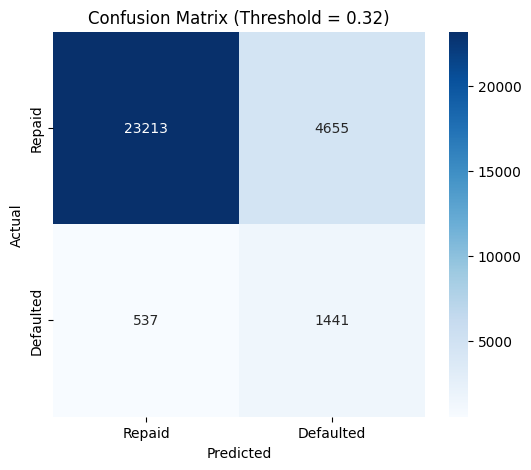

In [38]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for x_all, _ in val_loader:  
        x_all = x_all.to(device)
        outputs = model(x_all)
        probs = torch.sigmoid(outputs)
        y_val_probs.extend(probs.cpu().numpy())

y_val_probs = np.array(y_val_probs)
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
best_thresh_a = threshold_by_target_recall(y_val, y_val_probs, thresholds, target_recall=0.71)

y_test_probs = []
with torch.no_grad():
    for x_all, _ in test_loader:
        x_all = x_all.to(device)
        outputs = model(x_all)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())

y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh_a).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold for F-beta (β=2):", best_thresh_a)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_a:.2f})")
plt.show()

In [28]:
best_param = find_best_param(X_train, y_train)

Best params: {'subsample': 0.9, 'scale_pos_weight': np.float64(14.076196678606317), 'reg_lambda': 1.0, 'reg_alpha': 0.3, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.7}


In [29]:
# Model
model_b = xgb.XGBClassifier(
    **best_param,
    objective="binary:logistic",
    eval_metric=["auc"],
    n_estimators=800,
    random_state=42,
    n_jobs=-1,
    verbosity=1,
    early_stopping_rounds=100,
)

In [30]:
# Train
model_b.fit(X_train_xgb, y_train, eval_set=[(X_val_xgb, y_val)], verbose=True)

[0]	validation_0-auc:0.83419
[1]	validation_0-auc:0.84761
[2]	validation_0-auc:0.84937
[3]	validation_0-auc:0.85061
[4]	validation_0-auc:0.85113
[5]	validation_0-auc:0.85200
[6]	validation_0-auc:0.85257
[7]	validation_0-auc:0.85263
[8]	validation_0-auc:0.85303
[9]	validation_0-auc:0.85271
[10]	validation_0-auc:0.85328
[11]	validation_0-auc:0.85356
[12]	validation_0-auc:0.85354
[13]	validation_0-auc:0.85357
[14]	validation_0-auc:0.85379
[15]	validation_0-auc:0.85399
[16]	validation_0-auc:0.85402
[17]	validation_0-auc:0.85407
[18]	validation_0-auc:0.85436
[19]	validation_0-auc:0.85429
[20]	validation_0-auc:0.85443
[21]	validation_0-auc:0.85462
[22]	validation_0-auc:0.85462
[23]	validation_0-auc:0.85470
[24]	validation_0-auc:0.85485
[25]	validation_0-auc:0.85485
[26]	validation_0-auc:0.85491
[27]	validation_0-auc:0.85507
[28]	validation_0-auc:0.85508
[29]	validation_0-auc:0.85509
[30]	validation_0-auc:0.85526
[31]	validation_0-auc:0.85524
[32]	validation_0-auc:0.85528
[33]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,['auc']


Best threshold for F1: 0.5290805697441101
              precision    recall  f1-score   support

      Repaid       0.98      0.82      0.89     27868
   Defaulted       0.22      0.73      0.34      1978

    accuracy                           0.81     29846
   macro avg       0.60      0.78      0.62     29846
weighted avg       0.93      0.81      0.86     29846

Accuracy: 81.49%
ROC AUC: 0.859
TP=1444, FP=4991, TN=22877, FN=534
Accuracy for class 'Repaid': 82.09%
Accuracy for class 'Defaulted': 73.00%


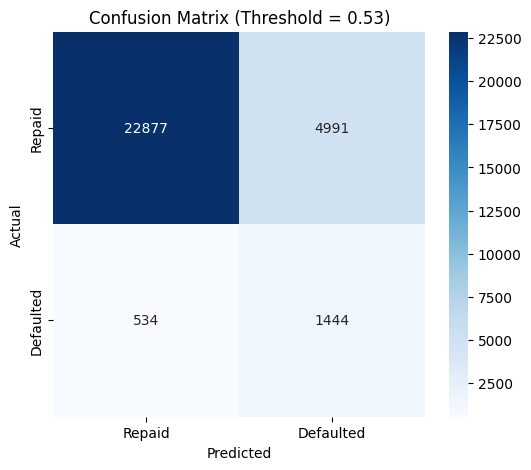

In [37]:
# Evaluation
y_probs = model_b.predict_proba(X_test_xgb)[:, 1]

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
best_thresh_b = threshold_by_target_recall(y_test, y_probs, thresholds, target_recall=0.73)

y_pred = (y_probs > best_thresh_b).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold for F1:", best_thresh_b)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_b:.2f})")
plt.show()

In [32]:
# Importance XGB
all_features = model_b.get_booster().feature_names
importance_dict = model_b.get_booster().get_score(importance_type="gain")
full_importance = {feat: importance_dict.get(feat, 0.0) for feat in all_features}
importance_df = (
    pd.DataFrame({
        "Feature": list(full_importance.keys()),
        "Importance": list(full_importance.values())
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)
print(importance_df)

                          Feature   Importance
0               DelinquencyBucket  1698.652710
1                DelinquencyScore  1040.542969
2              TotalPastDueCapped   829.418152
3     UtilizationBucketLateBucket   288.403503
4     UtilizationTimesDelinquency   155.876221
5               UtilizationPerAge   133.719009
6   RevolvingUtilizationCappedLog    97.272995
7             HasMajorDelinquency    56.899364
8             DebtToIncomeAgeRisk    51.891441
9        UtilizationPerCreditLine    45.241066
10                HighAgeRiskFlag    43.982548
11            IncomePerCreditLine    38.672436
12      LatePaymentsPerCreditLine    26.654411
13              HasAnyDelinquency     0.000000


In [33]:
# Shap
model_cpu = copy.deepcopy(model).cpu()

def shap_ohe(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    model_cpu.eval()
    with torch.no_grad():
        logits = model_cpu(X_tensor)
        probs = torch.sigmoid(logits).numpy()
    return probs

feature_names = list(X_train_nn_full.columns)

background = shap.sample(X_train_nn_full.astype('float32').values, 100)
explainer = shap.KernelExplainer(shap_ohe, background)

shap_values = explainer.shap_values(X_val_nn_full.astype('float32').values[:500])

shap_values_array = np.array(shap_values)
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

print("SHAP Importance:")
print(shap_importance)

  0%|          | 0/500 [00:00<?, ?it/s]

SHAP Importance:
                                         feature  mean_abs_shap
4                              UtilizationPerAge       0.014654
21   UtilizationBucketLateBucket_Very Low_NoLate       0.014418
33                             HasAnyDelinquency       0.008364
27                             UtilizationPerAge       0.007480
7                            DebtToIncomeAgeRisk       0.007402
6                  RevolvingUtilizationCappedLog       0.005902
17        UtilizationBucketLateBucket_Low_NoLate       0.005770
29                 RevolvingUtilizationCappedLog       0.005611
9                            IncomePerCreditLine       0.005594
18   UtilizationBucketLateBucket_Moderate_NoLate       0.004415
15                       DelinquencyBucket_Other       0.003438
5                            HasMajorDelinquency       0.003234
32                           IncomePerCreditLine       0.001937
10                             HasAnyDelinquency       0.001635
12                     

In [34]:
# Save NN model
torch.save(model.state_dict(), "cr_weights.pth")

In [35]:
# Save xgb model
model_b.save_model("cr_b.json")

In [40]:
# Save for hosting
joblib.dump(X_train_nn_full.columns.tolist(), "nn_col_order.pkl")
joblib.dump(best_thresh_a, "threshold_a.pkl")
joblib.dump(best_thresh_b, "threshold_b.pkl")
joblib.dump(num_imputer, "num_imputer.pkl")
joblib.dump(cat_imputer, "cat_imputer.pkl")
joblib.dump(robust_scaler, "robust_scaler.pkl")
joblib.dump(std_scaler, "std_scaler.pkl")
joblib.dump(num_col_order, "num_col_order.pkl")
joblib.dump(cat_maps, "cat_maps.pkl")
joblib.dump(cat_col_order, "cat_col_order.pkl")
joblib.dump(X_train_flags, "X_train_flags.pkl")
joblib.dump(skewed_col_order, "skewed_col_order.pkl")
joblib.dump(rare_maps, "rare_maps.pkl")

['rare_maps.pkl']